In [73]:
import os
import numpy as np 
import cv2
import matplotlib.pyplot as plt

In [74]:
path_dataset = '../dataset/'
dir_data = path_dataset + 'images'
dir_gt = path_dataset + 'groundtruth'

In [75]:
# Get the paths of every file given a parent directory
def get_all_files(path):
    vect = []
    for path, subdirs, files in os.walk(path):
        for name in files:
            if (name == '.DS_Store') | (name=='Readme.txt'):
                pass
            else:
                vect.append(os.path.join(path, name))
        vect = sorted(vect)
    return vect

In [76]:
gt = get_all_files(dir_gt)
print(np.transpose(gt[:5]))
masks = np.zeros((2240,240,320,1), dtype = np.bool)
# Get the masks 
n = 0
for i in gt:
  im = np.expand_dims(cv2.imread(i, cv2.IMREAD_GRAYSCALE), axis = -1)
  masks[n] = im
  n += 1

['../dataset/groundtruth/OperatorA_001-A_01.tiff'
 '../dataset/groundtruth/OperatorA_001-A_02.tiff'
 '../dataset/groundtruth/OperatorA_001-A_03.tiff'
 '../dataset/groundtruth/OperatorA_001-A_04.tiff'
 '../dataset/groundtruth/OperatorA_001-A_05.tiff']


(2240, 240, 320, 1)
[False, True]


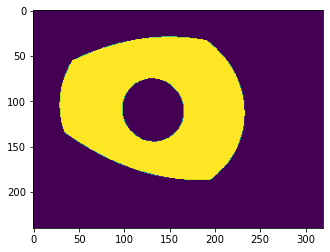

In [77]:
print(masks.shape)
im_test = np.squeeze(masks[400,:,:,:])
plt.imshow(im_test)
print([np.min(im_test), np.max(im_test)])

In [78]:
# Get the data 
images = get_all_files(dir_data)
data = np.zeros((2240,240,320,1))
n=0 
for i in images:
    im = np.expand_dims(cv2.imread(i, cv2.IMREAD_GRAYSCALE), axis = -1)
    im = (im-np.min(im))/(np.max(im)-np.min(im))
    data[n]= im
    n+=1

(2240, 240, 320, 1)
[0.0, 1.0]


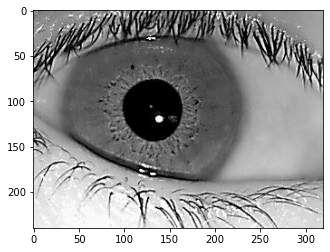

In [79]:
print(data.shape)
data_test = np.squeeze(data[400,:,:,:])
plt.imshow(data_test, cmap='gray')
print([np.min(data_test), np.max(data_test)])

In [80]:
# Save data 
import pickle 

pickle_out = open("iris_data", 'wb')
pickle.dump(data, pickle_out)           
pickle_out.close()

pickle_out = open("iris_masks", 'wb')
pickle.dump(masks, pickle_out)           
pickle_out.close()

In [81]:
#import data
data = np.load("iris_data", allow_pickle = True)
masks = np.load("iris_masks", allow_pickle = True)

In [82]:
import random
# Spliting 
x_train = []
y_train = []

x_test = []
y_test = []

indexes_to_test = []
random.seed(0)
for i in range(0,224):
    train = random.sample(range(0, 10), 5)
    for k in train:
        indexes_to_test.append(i*10+k)

print(indexes_to_test[:20])  
for i in range(0,len(data)):
    if i in indexes_to_test:
        x_train.append(data[i])
        y_train.append(masks[i])
    else:
        x_test.append(data[i])
        y_test.append(masks[i])

x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

[6, 9, 0, 2, 4, 17, 16, 14, 13, 12, 29, 23, 22, 27, 21, 31, 34, 32, 37, 30]


1.0


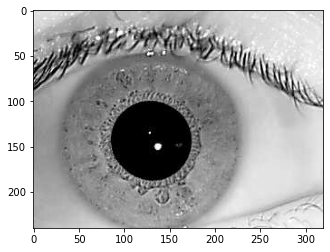

In [83]:
im_test = np.squeeze(x_train[0,:,:,:])
print(np.max(im_test))
plt.imshow(im_test, cmap='gray')

In [84]:
import skimage.io as io
import skimage.transform as trans
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='gpu')

RuntimeError: ML Compute device must be set before initialization.

In [ ]:
import tensorflow.keras.backend as K
smooth = 1e-5
def dice_coeff(y_true, y_pred, smooth=smooth):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def plot_history(history, name):
    #summarize history for loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.title.set_text('Model loss')
    ax1.set_ylabel('Loss value')
    ax1.set_xlabel('Epoch')
    #ax1.set_ylim([0, 0.1])
    ax1.legend(['Train', 'Validation'], loc='upper right')
    #summarize history for metrics
    ax2.plot(history.history['dice_coeff'])
    ax2.plot(history.history['val_dice_coeff'])
    ax2.set_ylim([0, 1])
    ax2.title.set_text('Model metrics')
    ax2.set_ylabel('Metrics value (DC)')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='lower right')
    fig.savefig(name+'.png')
    fig.savefig(name+'.pdf')

In [ ]:
from keras_unet.models import custom_unet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
def train(name,BN=False,US="deconv",NL=4,NF=8,DO=0.0,LR=1e-3,LF="binary_crossentropy",epochs=200, input_shape=(240,320,1), BS=8):
    model = custom_unet(
    input_shape=input_shape,
    use_batch_norm=BN,
    upsample_mode=US,
    num_layers=NL,
    num_classes=1,
    filters=NF,
    dropout=DO,
    output_activation='sigmoid')
    # Hyperparameters
    lr = LR
    epochs = epochs
    # Create optimizer, metrics and compile the model
    opt = tf.keras.optimizers.Adam(lr)
    model.compile(optimizer=opt, loss=LF, metrics=[dice_coeff])
    # Steps for training and validation (according to the batch size)
    #path_model = DATA_PATH+'/model/plain_unet_tfg1.h5'
    path_model = './models_saved/' + name
    # Callbacks used in training
    callbacks = [
        ModelCheckpoint(path_model, verbose=1, save_best_only=True, save_weights_only=True),
        ReduceLROnPlateau(monitor="val_loss", patience=10, factor=0.1, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=22, restore_best_weights=True)
    ]
    # Start training
    history = model.fit(x_train, y_train,
        validation_split = 0.15,
        batch_size = BS,
        epochs=epochs,
        callbacks=callbacks
    )
    save_fig = './training_progress/' + name[:-3]
    plot_history(history, save_fig)
    # Evaluate on Test set
    results_test = model.evaluate(x_test,y_test, verbose=1)
    print('\nTest Loss:\n',results_test)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [ ]:
#train(name='model.h5', NL=4, NF=4)

In [ ]:
# Load trained model and evaluate on test set
from keras_unet.models import custom_unet
model = custom_unet(
input_shape=(240, 320, 1),
use_batch_norm=False,
upsample_mode="deconv",
num_layers=4,
num_classes=1,
filters=4,
dropout=0.0,
output_activation='sigmoid')
model.load_weights('./models_saved/final_model.h5')
model.compile(loss="binary_crossentropy", metrics=[dice_coeff])
model.evaluate(x_test,y_test, verbose=1)
pred_test = model.predict(x_test)
pred = model.predict(data)

35/35 [==============================] - 3s 81ms/step - loss: 0.0405 - dice_coeff: 0.9663


In [ ]:
from skimage import img_as_bool
from skimage.measure import label
def refine_mask(out):
    results = (out>0.5)*1.0
    img_bw = img_as_bool(results)
    labels = label(img_bw, return_num=False)
    maxCC_nobcg = labels == np.argmax(np.bincount(labels.flat, weights=img_bw.flat))
    results = maxCC_nobcg*1.0
    return results
    
def compute_dice(gt, out):
    dice_val = np.sum([(gt)&(out>0.5)])*2.0/(np.sum(gt)+np.sum(out>0.5))
    return dice_val

print(compute_dice(y_test, pred_test))
print(compute_dice(y_test, refine_mask(pred_test)))

0.973478864676755
0.9736486404538169


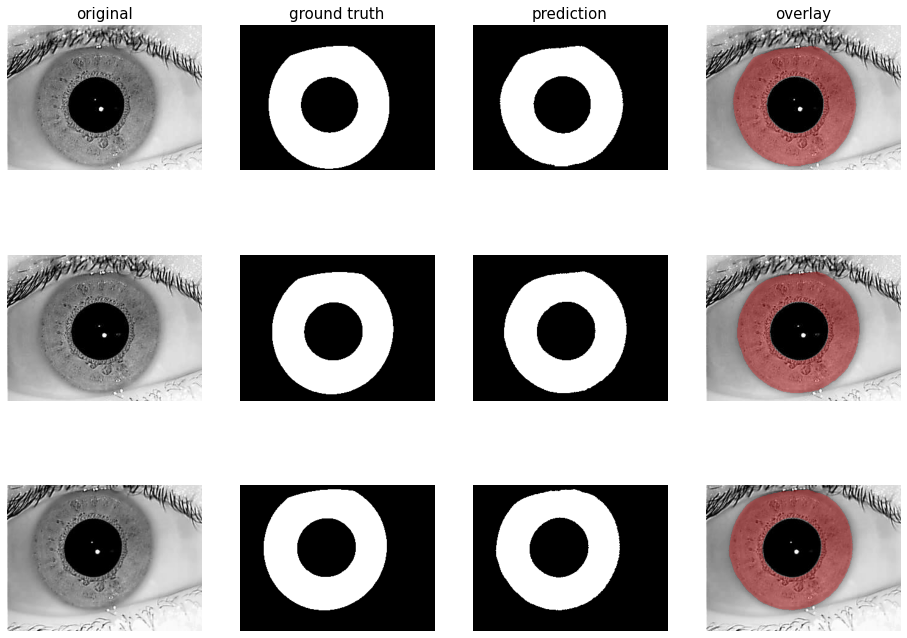

In [ ]:
from keras_unet.utils import plot_imgs
plot_imgs(
    org_imgs=x_test, # required - original images
    mask_imgs=y_test, # required - ground truth masks
    pred_imgs=pred_test>0.5, # optional - predicted masks
    nm_img_to_plot=3,alpha=0.3) # optional - number of images to plot

In [ ]:
from tqdm import tqdm
from PIL import Image
# Save DL masks
images = get_all_files(dir_data)
save_folder = '../new datasets/masks_DL'
if not os.path.exists(save_folder_masks):
    os.mkdir(save_folder_masks)
    numb = ["{0:03}".format(i) for i in range(1,225)]
    for i in numb:
        os.mkdir(os.path.join(save_folder_masks,i))

for i in tqdm(images):
    im = cv2.imread(i,cv2.IMREAD_GRAYSCALE)
    im = (im-np.min(im))/(np.max(im)-np.min(im))
    im = np.expand_dims(im,-1)
    im = np.expand_dims(im,axis=0)
    pred = model.predict(im)
    pred = pred > 0.5
    pred = refine_mask(np.squeeze(pred)).astype(np.uint8)
    im = Image.fromarray(pred)
    save_path = os.path.basename(os.path.dirname(i)) + '/' + os.path.basename(i)[:-4]
    im.save(os.path.join(save_folder,save_path)+'.png')

100%|██████████| 2240/2240 [01:16<00:00, 29.35it/s]


In [ ]:
# Hard attention attempt

# Create the bounding box coordinates of GT masks
dir_gt = '../dataset/groundtruth'
gt = get_all_files(dir_gt)

bbox = np.zeros((2240,4), dtype=np.uint32)
n = 0
for i in gt:
  im = np.expand_dims(cv2.imread(i, cv2.IMREAD_GRAYSCALE), axis = -1)
  x,y,w,h = cv2.boundingRect(im)
  bbox[n] = [x,x+w,y,y+h]
  n += 1

bbox_test = []
bbox_train = []
indexes_to_test = []
random.seed(0)
for i in range(0,224):
    train = random.sample(range(0, 10), 5)
    for k in train:
        indexes_to_test.append(i*10+k)

print(indexes_to_test[:20])  
for i in range(0,len(data)):
    if i in indexes_to_test:
        bbox_train.append(bbox[i])
    else:
        bbox_test.append(bbox[i])

bbox_train = np.array(bbox_train)
bbox_test = np.array(bbox_test)

[6, 9, 0, 2, 4, 17, 16, 14, 13, 12, 29, 23, 22, 27, 21, 31, 34, 32, 37, 30]


In [ ]:
# Function to define the building block of the hard attention U-Net
def double_conv(inputs,
    use_batch_norm=False,
    filters=16,
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same"):
    c = Conv2D(
        filters,
        (3,3),
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    c = Conv2D(
        filters,
        (3,3),
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    return c

In [ ]:
# Model to predict the bounding box coordinates (1st training step)
def final_model1(model):
    inp = model.input
    mask = Input((240,320,1))
    x1=model.layers[2].output
    x2=model.layers[5].output
    x3=model.layers[8].output
    x4=model.layers[11].output
    encoder_final=model.layers[14].output
    flat = MaxPooling2D(2)(x4)
    flat1 = Flatten()(flat)
    coord = Dense(4)(flat1)
    return Model(inputs=[inp], outputs=[coord])

# Model to predict the final mask (2nd training step, training only decoder using the weights from the  1st training step)
def final_model2(model3):
    inp = model3.input
    mask = Input((240,320,1))
    x1 = model3.layers[2].output
    x2 = model3.layers[5].output
    x3 = model3.layers[8].output
    x4 = model3.layers[11].output
    filt = 64

    up1 = Conv2DTranspose(filt, (2,2), strides=(2,2), padding="same")(x4)
    up1 = concatenate([x3, up1])
    up1 = double_conv(up1, use_batch_norm=False,filters=filt)
    filt /= 2
    up2 = Conv2DTranspose(filt, (2,2), strides=(2,2), padding="same")(up1)
    up2 = concatenate([x2, up2])
    up2 = double_conv(up2, use_batch_norm=False,filters=filt)
    filt /= 2
    up3 = Conv2DTranspose(filt, (2,2), strides=(2,2), padding="same")(up2)
    up3 = concatenate([x1, up3])
    up3 = double_conv(up3, use_batch_norm=False,filters=filt)
    filt /= 2
    outputs = Conv2D(1, (1, 1))(up3)*mask
    outputs = Conv2D(1, (1,1), activation="sigmoid")(outputs)
    model = Model(inputs=[inp,mask], outputs=[outputs])
    return model

In [ ]:
# 1st training step
model3 = final_model1(model)
opt = tf.keras.optimizers.Adam(1e-3)
model3.compile(loss="mean_squared_error",optimizer=opt)
path_model = './models_saved/' + 'encoder_final2'
# Callbacks used in training
callbacks = [
    ModelCheckpoint(path_model, verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor="val_loss", patience=10, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=22, restore_best_weights=True)
]
model3.load_weights(path_model)
#history = model3.fit([x_train],bbox_train,validation_split=0.15,batch_size=16,epochs=3,callbacks=callbacks)

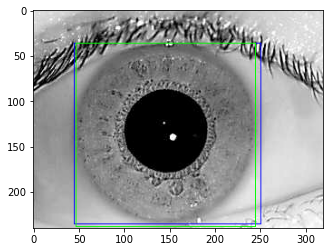

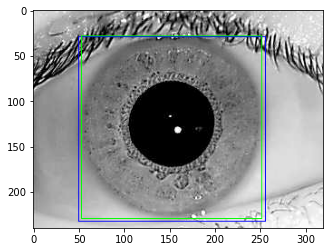

In [ ]:
# Visualization of the bounding box predictions
out = model3.predict(x_test)
for ind in range(0,2):
    bbox_out = np.uint16(np.rint(out[ind]))
    bbox_true = bbox_test[ind]
    im_test_out = np.squeeze(y_test[ind])
    im_test_in = np.squeeze(x_test[ind])
    bbox_im = np.zeros(im_test_in.shape)
    bbox_im[bbox_out[2]:bbox_out[3],bbox_out[0]:bbox_out[1]] = 255.0
    im_test_in = cv2.cvtColor(np.float32(im_test_in),cv2.COLOR_GRAY2RGB)
    cv2.rectangle(im_test_in, (bbox_out[1],bbox_out[3]), (bbox_out[0],bbox_out[2]), (0,0,1), 1)
    cv2.rectangle(im_test_in, (bbox_true[1],bbox_true[3]), (bbox_true[0],bbox_true[2]), (0,1,0), 1)
    plt.imshow(im_test_in)
    plt.show()

In [89]:
# Function to create the bounding box masks with epsilon pixel value otside the mask 
def create_dataset(epsilon):
    coord_train = model3.predict(x_train)
    coord_train = np.uint16(np.rint(coord_train))
    mask_train = np.zeros((1120,240,320,1))+epsilon
    for i in range(len(coord_train)):
        mask_train[i,coord_train[i,2]:coord_train[i,3],coord_train[i,0]:coord_train[i,1],0] = 1.0

    coord_test = model3.predict(x_test)
    coord_test = np.uint16(np.rint(coord_test))
    mask_test = np.zeros((1120,240,320,1))+epsilon
    for i in range(len(coord_train)):
        mask_test[i,coord_test[i,2]:coord_test[i,3],coord_test[i,0]:coord_test[i,1],0] = 1.0
    return [mask_train, mask_test]

In [87]:
def plot_history(history, name):
    #summarize history for loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.title.set_text('Model loss')
    ax1.set_ylabel('Loss value')
    ax1.set_xlabel('Epoch')
    #ax1.set_ylim([0, 0.1])
    ax1.legend(['Train', 'Validation'], loc='upper right')
    #summarize history for metrics
    ax2.plot(history.history['dice_coeff'])
    ax2.plot(history.history['val_dice_coeff'])
    ax2.set_ylim([0, 1])
    ax2.title.set_text('Model metrics')
    ax2.set_ylabel('Metrics value (DC)')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='lower right')
    fig.savefig(name+'.png')
    fig.savefig(name+'.pdf')

# Function for the 2nd training step
def train_decoder(name, epsilon):
    model3b = final_model2(model3)
    for layer in model3b.layers[:12]:
        layer.trainable = False

    opt = tf.keras.optimizers.Adam(1e-3)
    model3b.compile(loss="mean_squared_error",optimizer=opt,metrics=[dice_coeff])
    path_model = '/Users/faaronts/Desktop/MAIA/2nd semester/AIA:ML_DL Project/Codes/Segmentation/DL/models_saved/' + name
    # Callbacks used in training
    callbacks = [
        ModelCheckpoint(path_model, verbose=1, save_best_only=True, save_weights_only=True),
        ReduceLROnPlateau(monitor="val_loss", patience=10, factor=0.1, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=22, restore_best_weights=True)
    ]
    # Start training
    mask_train = create_dataset(epsilon)[0]
    mask_test = create_dataset(epsilon)[1]
    history = model3b.fit([x_train, mask_train],y_train,validation_split=0.15,batch_size=8,epochs=200,callbacks=callbacks)
    save_fig = '/Users/faaronts/Desktop/MAIA/2nd semester/AIA:ML_DL Project/Codes/Segmentation/DL/training_progress/' + name[:-3]
    plot_history(history, save_fig)
    # Evaluate on Test set
    results_test = model3b.evaluate([x_test,mask_test],y_test, verbose=1)
    print('\nTest Loss:\n',results_test)

In [88]:
# 2nd training step
train_decoder('decoder_final4_x4.h5',0.6)

Epoch 1/200
 94/119 [======================>.......] - ETA: 4s - loss: 0.1744 - dice_coeff: 0.4751

KeyboardInterrupt: 